In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

In [2]:
import torch
from diffusers import DDPMPipeline, AutoencoderKL
from tqdm import tqdm
from matplotlib import pyplot as plt

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:21<00:00, 46.53it/s]


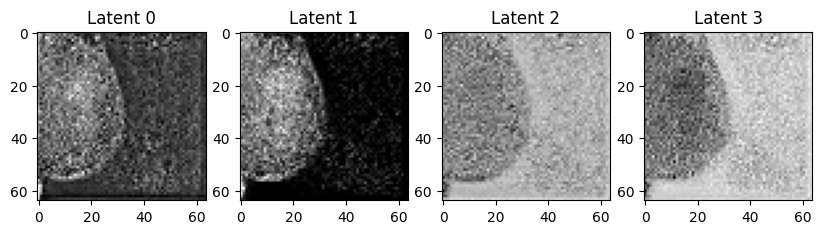

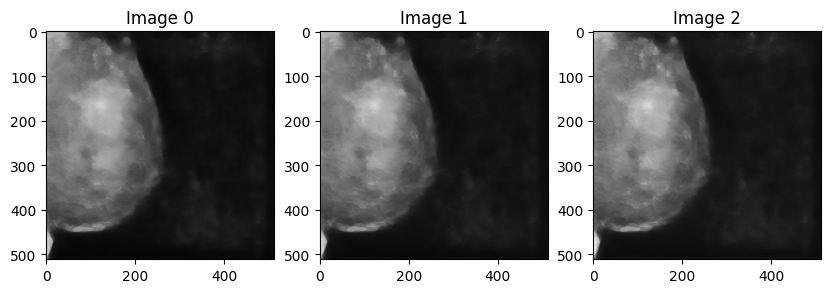

In [8]:
batch_size = 1
pipe_name = 'Likalto4/latent_32_ga-8'

# load pipeline
pipeline = DDPMPipeline.from_pretrained(pipe_name)
model = pipeline.unet
noise_scheduler = pipeline.scheduler
# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# denoise images
latent_inf = torch.randn(batch_size,4,64,64).to(device)
latent_inf *= noise_scheduler.init_noise_sigma # init noise is 1.0 in vanilla case
# markov chain
for t in tqdm(noise_scheduler.timesteps): # markov chain
    latent_inf = noise_scheduler.scale_model_input(latent_inf, t) # # Apply scaling, no change in vanilla case
    with torch.no_grad(): # predict the noise residual with the unet
        noise_pred = model(latent_inf, t).sample
    latent_inf = noise_scheduler.step(noise_pred, t, latent_inf).prev_sample # compute the previous noisy sample x_t -> x_t-1

# show latents
fig, ax = plt.subplots(1,4, figsize=(10,5))
for i in range(4):
    ax[i].imshow(latent_inf[0,i].cpu().numpy(), cmap='gray')
    ax[i].set_title(f'Latent {i}')

# load vae    
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.requires_grad_(False)
# send vae to accelerator
vae.to(device)

# first we unscale
latent_inf = latent_inf/ vae.config.scaling_factor
# decode
with torch.no_grad():
    im = vae.decode(latent_inf).sample
# show images
fig, ax = plt.subplots(1,3, figsize=(10,5))
for i in range(3):
    ax[i].imshow(im[0,i].cpu().numpy(), cmap='gray')
    ax[i].set_title(f'Image {i}')

In [4]:
# save one channel as png
plt.imsave('latent.png', im[0,0].cpu().numpy(), cmap='gray')